# The Bias-Variance Tradeoff

In this short notebook, we'll explore a phenomenon often referred to as the _bias-variance tradeoff_.  The idea is that  a machine learning model is naturally _biased_ in that it makes assumptions about the dataset.  A linear regression model, for example, makes the assumption that your data is linear.  Contrast this with a model's built-in flexibility, or _variance_.  This notion captures a model's ability to modify its output to match the training data.  A high-degree polynomial regression is extremely variant.  Let's see this in action.

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math
from statistics import mean

%matplotlib inline

N = 40         # max poly degree
NOISE = .5     # amount of noise in the data

plt.style.use('fivethirtyeight')

First, we create and plot a sample dataset.  I build this by adding noise to a function of _ground truth_: this is the true function that my data is based upon.  In a real-life situation, you wouldn't have access to this _ground truth_ function, and so we hope to approximate it with our machine learning models.

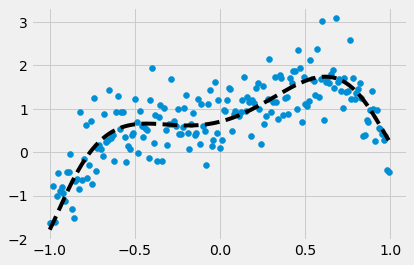

In [120]:
x = np.arange(-1,1,.01)

true_model = lambda x:  3*x**2 + 5 * np.vectorize(math.sin)(x**(4) + 3) +x
y_true = true_model(x) 

y = y_true + (NOISE * np.random.randn(y_true.size))

plt.scatter(x,y)
plt.plot(x, y_true, 'k--')
plt.show()

Okay, so let's fit a line to this, and also a quadratic, a cubic, quartic, _etc._; all the polynomials up to degree `N`.  First, we extend our dataset to include these features.

In [121]:
df = pd.DataFrame({'x':x})
for i in range(2,N+1):
    df['x^' + str(i)] = x**i

df.head()

,x,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10,...,x^31,x^32,x^33,x^34,x^35,x^36,x^37,x^38,x^39,x^40
0,-1.00,1.0000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000
1,-0.99,0.9801,-0.970299,0.960596,-0.950990,0.941480,-0.932065,0.922745,-0.913517,0.904382,...,-0.732303,0.724980,-0.717731,0.710553,-0.703448,0.696413,-0.689449,0.682555,-0.675729,0.668972
2,-0.98,0.9604,-0.941192,0.922368,-0.903921,0.885842,-0.868126,0.850763,-0.833748,0.817073,...,-0.534575,0.523883,-0.513405,0.503137,-0.493075,0.483213,-0.473549,0.464078,-0.454796,0.445700
3,-0.97,0.9409,-0.912673,0.885293,-0.858734,0.832972,-0.807983,0.783743,-0.760231,0.737424,...,-0.388977,0.377308,-0.365988,0.355009,-0.344358,0.334028,-0.324007,0.314287,-0.304858,0.295712
4,-0.96,0.9216,-0.884736,0.849347,-0.815373,0.782758,-0.751447,0.721390,-0.692534,0.664833,...,-0.282103,0.270819,-0.259986,0.249587,-0.239603,0.230019,-0.220819,0.211986,-0.203506,0.195366


Now we generate each of the models, fit them, and make preditions.

In [122]:
Xs = [df[list(df.columns[:i])].values for i in range(1,df.shape[1])]
models = [LinearRegression().fit(X, y) for X in Xs]
predictions = [model.predict(X) for X,model in zip(Xs,models)]

Now, let's visualize the models.

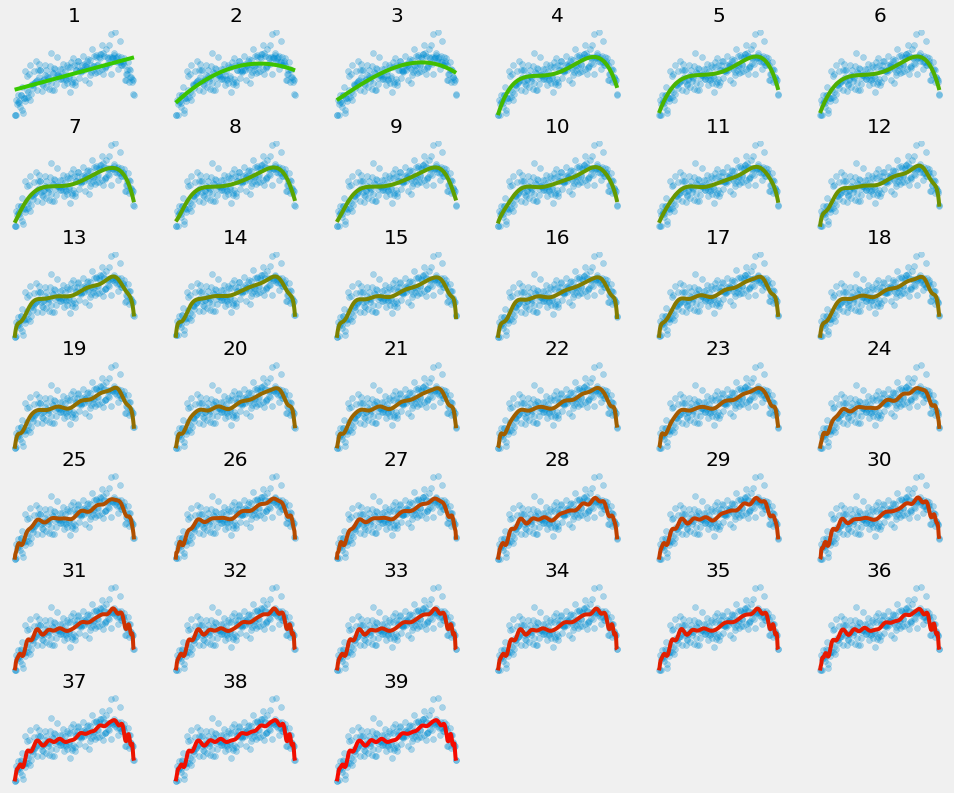

In [123]:
def make_color_value(i):
    value = str(hex(i)[2:]) 
    if len(value) < 2:
        return '0' + value
    return value

colors = ['#' + make_color_value(55+i) + make_color_value(200-i) + '00' for i in range(0,200,200//N)]
fig = plt.figure(figsize=(15,13))
plots = []

# make a grid of subplots
n = math.floor(N / math.sqrt(N)) + 1
m = N//(n) + 1

for i in range(0,N-1):
    plots.append(fig.add_subplot(n,m,1+i))
    plots[i].scatter(x,y, alpha=0.3)
    plots[i].plot(x, predictions[i], c=colors[i])
    plots[i].set_title(str(i+1))
    plots[i].get_xaxis().set_visible(False)
    plots[i].get_yaxis().set_visible(False)
    
plt.show()

Let's also isolate a few models and show them.

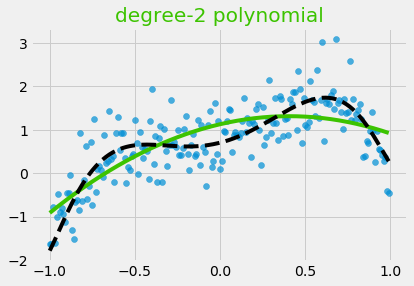

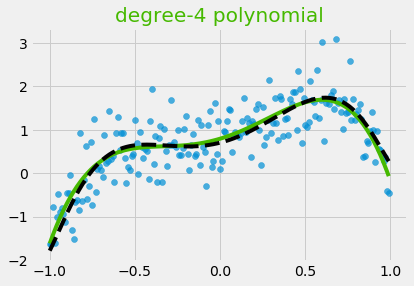

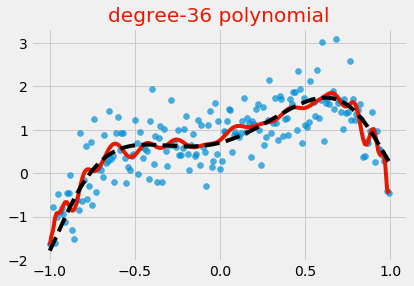

In [124]:
def quick_plot(i):
    Xi = df[list(df.columns[:i])].values
    mi = LinearRegression().fit(Xi,y)

    predi = mi.predict(Xi)

    plt.scatter(x,y, alpha=0.7)
    plt.plot(x, predi, c=colors[i-1])
    plt.plot(x, y_true, 'k--')
    title = plt.title("degree-{} polynomial".format(i))
    plt.setp(title, color=colors[i-1])  
    plt.show()

quick_plot(2)
quick_plot(4)
quick_plot(36)

It's clear that the too-low-dimensional models are a bad fit, they're **underfit**.  The too-high-dimensional models certainly appear to be **overfit**.  How can we justify that with our data?  They technically have less error than the degree-4 model.  Let's see that: we'll plot the error against the "model flexibility", _i.e._ the degree of the polynomial in the fit. 

In [125]:
def rmse(preds, true_y=y):
    """The error of the model."""
    return math.sqrt(mean((true_y-preds)**2))

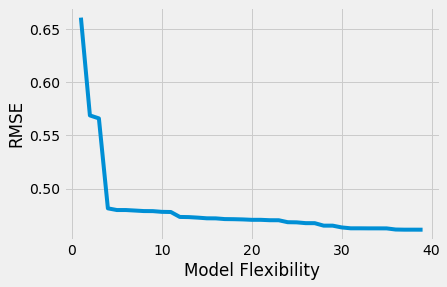

In [126]:
model_size = list(range(1,N))

training_rmse = []
for i in model_size:
    training_rmse.append(rmse(predictions[i-1]))

plt.plot(model_size, training_rmse, label="Training Error")
plt.xlabel("Model Flexibility")
plt.ylabel("RMSE")
plt.show()

So a few things I note from this is that there appears to be a sharp change in error once we start being "appropriately biased" in our dataset.  However, the error of my model still does decrease.  This seems a bit silly, but I could in theory create a model that's so flexible it can fit all the points.  These variations clearly won't hold up when we start seeing data that we haven't seen before.

# Test Data 

Let's generate some new data from the same distribution, and see which models do best at predicting it.

In [127]:
x_test = np.random.randn(500)
x_test = np.array([i for i in x_test if abs(i) <= 1])
y_test = true_model(x_test) + (NOISE * np.random.randn(x_test.size))

df_test = pd.DataFrame({'x':x_test},index=list(range(x_test.size)))
for i in range(2,N+1):
    df_test['x^' + str(i)] = x_test**i

test_Xs = [df_test[list(df_test.columns[:i])].values for i in range(1,df_test.shape[1])]
test_predictions = [model.predict(X) for X,model in zip(test_Xs,models)]

Let's take a quick look at our training and test data.

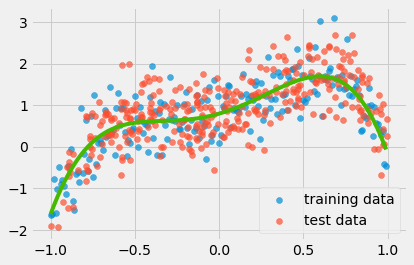

In [128]:
X4 = df[list(df.columns[:4])].values
m4 = LinearRegression().fit(X4,y)

pred4 = m4.predict(X4)

plt.scatter(x, y, label='training data', alpha=0.7)
plt.scatter(x_test, y_test, label='test data', alpha=0.7)
plt.plot(x, pred4, c=colors[3])
plt.legend(loc='lower right')
plt.show()

Clearly, our training and test data come from the same distribution.  However, let's look at our models' predictions.

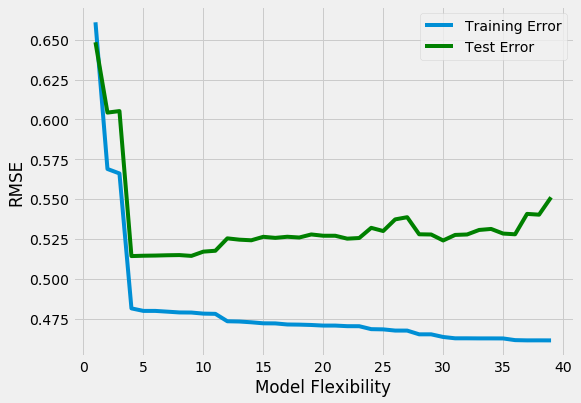

In [129]:
test_rmse = []
for i in model_size:
    test_rmse.append(rmse(test_predictions[i-1], true_y=y_test))

fig = plt.figure(figsize=(8,6))
plt.plot(model_size, training_rmse, label="Training Error")
plt.plot(model_size, test_rmse, c='g', label="Test Error")
plt.xlabel("Model Flexibility")
plt.ylabel("RMSE")
plt.legend(loc='upper right')
plt.show()

Note that there is an overall difference between the training and the test error: that's because the test data was chosen to be less noisey than the training data, and it's not a big deal.  The key insight is that there is a "sweet spot" of lowest error in the test data: too little flexible, and our model's bias will create more error.  Too much flexibility, and we start fitting the noise in our dataset, and our model's bias will create more error.  Thus, we want to choose a model which attempts to split the difference to try to find the smallest _test_ error.